In [1]:
%load_ext autoreload
%autoreload 2

# NLP Twitter Sentiment Analysis Project
<font size="4"> Author: Jeffrey Hanif Watson </font>

## Overview
In recent years, Twitter has emerged as a prominent platform for marketing and targeted advertising. It is also a valuable conduit for the collection of consumer data, and natural language processing (NLP) methods can provide a solution for companies seeking to track consumer sentiment with respect to their brands and products. This project developed and implemented several NLP models to classify tweets as negative or positive. 

Data cleaning and augmentation, EDA, modeling, and evaluation were performed, and a random forest classifier was chosen as the the final model for the project. Because we wanted to avoid both false positives and false negatives for this project, an accuracy measure of F1 was employed since it is sensitive to both types of error. An F1 score is a mix of both precision and recall (F1=1 means perfect recall and precision), so interpretation of the results is more easily described in terms of recall and precision. 

An F1 accuracy score of 0.89 (recall=.85, precision=.94) was attained at the end of the project's modeling process. The recall score of .85 meant that 85% of negative tweets were correctly classified as negative, while the precision score of .94 indicated that 94% of tweets classified as negative were truly negative. 

An alternate logistic regression model with an F1 accuracy score of 0.89 (recall=.83, precision=.97) is also available for use by interested parties.

## Business Understanding:
Companies can benefit from understanding how consumers perceive their brands and products, and sentiment analysis of text data from twitter can help provide this knowledge in a timely manner. A surge in negative sentiment would indicate a crisis of some sort that would need to be addressed quickly, and thus negative sentiment was deemed to be the most important class for modeling purposes in the project. However, data on the level of positive sentiment is still very valuable information, so a model that captures both sentiments as accurately as possible is most desirable.  

## Data Understanding:
The baseline data for this project consists of a csv file containing 9,093 rows of text data (tweets, brand/product ids, sentiments labels) originally sourced from [Twitter](https://twitter.com/?lang=en) and collected into the [crowdflower/brands-and-product-emotions](https://data.world/crowdflower/brands-and-product-emotions) dataset. From the overwhelming amount of SXSW hashtags, and numerous references to the iPad 2 (which was released on March 2nd, 2011), it appears that the data was collected during the 2011 South by Southwest festival (which ran from March 11th to March 20th). The data contained ternary (positive, neutral, negative) sentiment data which was filtered down to binary (positive, negative) classes for modeling purposes. 

During the modeling process, the class imbalance in the data was shown to interfer with model performance, and additional negative sentiment data was used to augment the baseline data. 1,117 rows of negative general topic tweets were obtained from [Kaggle](https://www.kaggle.com/shashank1558/preprocessed-twitter-tweets), and an additional 1,219 negative apple tweets were procured from [data.world](https://data.world/crowdflower/apple-twitter-sentiment). This data augmentation greatly improved model performance.

## Package Imports & Setup 
Importing the required packages, setting the project path and notebook styling.

In [2]:
# imports
import os, sys, string, re, itertools, more_itertools, random, collections

from collections import Counter
from more_itertools import take

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

import pandas as pd
import numpy as np

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# # updates for nltk helper packages if needed
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
                           

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from src import visualizations as vz
from src import functions as fn
          
# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')
pd.options.display.max_rows = 300

## Data Preparation I: (Exploring the Data)

## `dir` Check
Checking where we are before setting the path.

In [3]:
!pwd

/Users/dsbox/Documents/Flatiron/p_4_project/nlp_sentiment_project/notebooks/exploratory


## Importing Data:
Setting path to the data, creating data frame, and checking first five rows.

In [4]:
path = os.path.join(gparent, 'data/raw',\
                           'judge-1377884607_tweet_product_company.csv')
df = pd.read_csv(path, encoding='unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Checking the DF Info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


<font size="4">We are going to look at the single missing tweet right now and save the nulls in the second column for later.</font>

## Checking the Null Tweet:
We have one null value in the `tweet` column we need to deal with.

In [6]:
df[df['tweet_text'].isnull()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,NaN,No emotion toward brand or product


## Dropping the Null Tweet

In [7]:
df.drop(6, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## Renaming Columns:
The original names are a bit unwieldy.

In [9]:
rename_dict = {'tweet_text': 'tweet', 
               'emotion_in_tweet_is_directed_at': 'brand_product', 
               'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion' }
df.rename(columns=rename_dict, inplace=True)
df.head()

,tweet,brand_product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Shortening `emotion` Labels
Same reasoning as above.

In [10]:
df['emotion'] = df['emotion'].replace(['Negative emotion',
                                       'Positive emotion',
                                       'No emotion toward brand or product'],
                                      ['Negative',
                                       'Positive',
                                       'Neutral'])

## Checking for Duplicated Tweets:
If there are duplicated tweets, they probably won't add usefull information and most likely will be dropped.

In [11]:
# checking the shape baseline shape and saving it to a variable
original_shape = df.shape
original_shape

(9092, 3)

In [12]:
# filtering for dupes
dupes = df[df['tweet'].duplicated()]

In [13]:
# checking the number of dupes
len(dupes)

27

## Examining the Dupes:
Since there are only 27 dupes, we'll just examine all of them.

In [14]:
dupes

,tweet,brand_product,emotion
467,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive
775,Google to Launch Major New Social Network Call...,NaN,Neutral
2231,Marissa Mayer: Google Will Connect the Digital...,NaN,Neutral
2558,Counting down the days to #sxsw plus strong Ca...,Apple,Positive
3812,Win free ipad 2 from webdoc.com #sxsw RT,iPad,Positive
3813,Win free iPad 2 from webdoc.com #sxsw RT,iPad,Positive
3949,Really enjoying the changes in Gowalla 3.0 for...,Android App,Positive
3961,"#SXSW is just starting, #CTIA is around the co...",Android,Positive
4896,"Oh. My. God. The #SXSW app for iPad is pure, u...",iPad or iPhone App,Positive
5337,RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ...,NaN,Neutral


<font size="4">Other than the fact that there are a lot of retweets in the dupes, nothing else really stands out. Since we are losing only 27 rows of data, dropping seems like a safe decision.</font>

## Dropping Dupes

In [15]:
df.drop_duplicates(subset='tweet',inplace=True)
df.reset_index(drop=True, inplace=True)

In [16]:
# comparing shapes
print(f'original shape: {original_shape}')
print(f'new shape: {df.shape}')

original shape: (9092, 3)
new shape: (9065, 3)


## Checking for Links:
Checking for url and {link} strings and getting a link count.

In [17]:
# checking for links
tweets = df['tweet']
links = fn.find_strings(tweets, r'(https*\S+)|(\{link\})')
print(links[:25])
len(links)

[[('http://ht.ly/49n4M', '')], [('http://bit.ly/ieaVOB', '')], [('http://bit.ly/gVLrIn', '')], [('http://j.mp/grN7pK)', '')], [('http://bit.ly/aXZwxB', '')], [('http://tinyurl.com/4nqv92l', '')], [('http://bit.ly/hTdFim', '')], [('http://t.co/kfN3f5Q', '')], [('http://t.co/g4GZypV', '')], [('http://tumblr.com/x6t1pi6av7', '')], [('http://bit.ly/hTdFim', '')], [('http://bit.ly/etsbZk', '')], [('http://t.co/A3xvWc6', '')], [('http://itunes.apple.com/us/app/holler-gram/id420666439?mt=8', '')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')]]


4175

<font size="4">Since these strings don't add sentiment information, we'll strip them out during the cleaning process.</font>

## Adding a Hashtag Column:
Hashtags have the potential to contain value information, so we'll create a new column to help explore them.

In [18]:
# copying hashtags to a new column and setting any empty lists to NaNs
df['hashtags'] = df['tweet'].apply(lambda x: 
                                   re.findall(r'\B#\w*[a-zA-Z]+\w*', x))

In [19]:
# checking info & first 5 rows
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9065 entries, 0 to 9064
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          9065 non-null   object
 1   brand_product  3280 non-null   object
 2   emotion        9065 non-null   object
 3   hashtags       9065 non-null   object
dtypes: object(4)
memory usage: 283.4+ KB
None


,tweet,brand_product,emotion,hashtags
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,"[#RISE_Austin, #SXSW]"
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,[#SXSW]
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,"[#iPad, #SXSW]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,[#sxsw]
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,[#SXSW]


## Exploring the Hashtags
Creating a list and checking the length.

In [20]:
# creating a hashtag list
hashlists = df['hashtags'].tolist()

In [21]:
print(f'hashlists length: {len(hashlists)}')

hashlists length: 9065


In [22]:
hashlists[:5]

[['#RISE_Austin', '#SXSW'],
 ['#SXSW'],
 ['#iPad', '#SXSW'],
 ['#sxsw'],
 ['#SXSW']]

In [23]:
hash_counts = []
for listy in hashlists:
    hash_counts.append(len(listy))
print(f'total tags: {np.sum(hash_counts)}')
print(f'ave tags: {np.sum(hash_counts)/len(hash_counts)}')
print(f'max tags: {max(hash_counts)}')

total tags: 15779
ave tags: 1.7406508549365691
max tags: 12


<font size="5"> There are 15,779 hashtags.</font>

<font size="5"> The average number of hashtags per tweet is 1.74.</font>

<font size="5"> The maximum number of hashtags in a single tweet is 12.</font>

<font size ="5"> Below is the tweet with the max number of hashtags and a list of the hashtags.</font>

In [24]:
print(df.iloc[np.argmax(hash_counts)][0])

print(hashlists[np.argmax(hash_counts)])

iPad 2 and Its Rivals: How They Stack Up {link} #bnet #biz #ipad2 #apple #sxsw #ipad #tablet #xoom #tech #laptop #pics #sale
['#bnet', '#biz', '#ipad2', '#apple', '#sxsw', '#ipad', '#tablet', '#xoom', '#tech', '#laptop', '#pics', '#sale']


## Checking for Empty Lists & Converting to NaNs
Converting and checking length.

In [25]:
df['hashtags'] = df['hashtags'].apply(lambda x: np.nan if len(x) == 0 else x)

In [26]:
df['hashtags'].isna().sum()

10

## Checking Tweets with no Hashtags
There are 10 tweets that don't have a hashtag that we'll examine.

In [27]:
df[df['hashtags'].isna()]

,tweet,brand_product,emotion,hashtags
307,And a few are Android too RT @mention 10 New M...,Android App,Positive,NaN
471,"Before It Even Begins, Apple WinsåÊ#SxSW, {lin...",Apple,Positive,NaN
768,Google to Launch Major New Social Network Call...,Google,Positive,NaN
791,Google to Launch Major New Social Network Call...,NaN,Neutral,NaN
930,To buy or not to buy RT @mention Before It Eve...,Apple,Positive,NaN
1139,ÛÏ@mention The 10 most dangerous IPhone apps....,NaN,Neutral,NaN
2427,Extra iPad 2 for sale in Austin convention cen...,NaN,Neutral,NaN
3477,GENIUS behind Google Circles.\n¡á¾_Î¾Ð¡____...,Other Google product or service,Positive,NaN
5015,RT @mention,NaN,Neutral,NaN
5538,"RT @mention Before It Even Begins, Apple Winså...",Apple,Positive,NaN


<font size="4">It doesn't appear that there is any pattern to the tweets with no hashtags.</font>

## Checking the Hashtag Set
Removing NaNs, making a list, converting to lowercase and forming a set.

In [28]:
# removing Nans
hashlists = df.hashtags.tolist()
hashlists = [h_list for h_list in hashlists if str(h_list) != 'nan']

In [29]:
# checking length
len(hashlists)

9055

In [30]:
# unpacking hashtags & lowercasing
hashtags = [hashtag.lower() for h_list in hashlists for hashtag in h_list]

In [31]:
# checking work
hashtags[:5]

['#rise_austin', '#sxsw', '#sxsw', '#ipad', '#sxsw']

In [32]:
# making a set and checking length
len(set(hashtags))

1460

<font size="4">There are 1,460 unique hashtags.</font>

## Visualizing the Top 20 Hashtags
Graphing the counts and frequencies of the top 20 hashtags.

In [33]:
# creating a dataframe for the plots
hts = pd.DataFrame(hashtags, columns=['hashtags'])

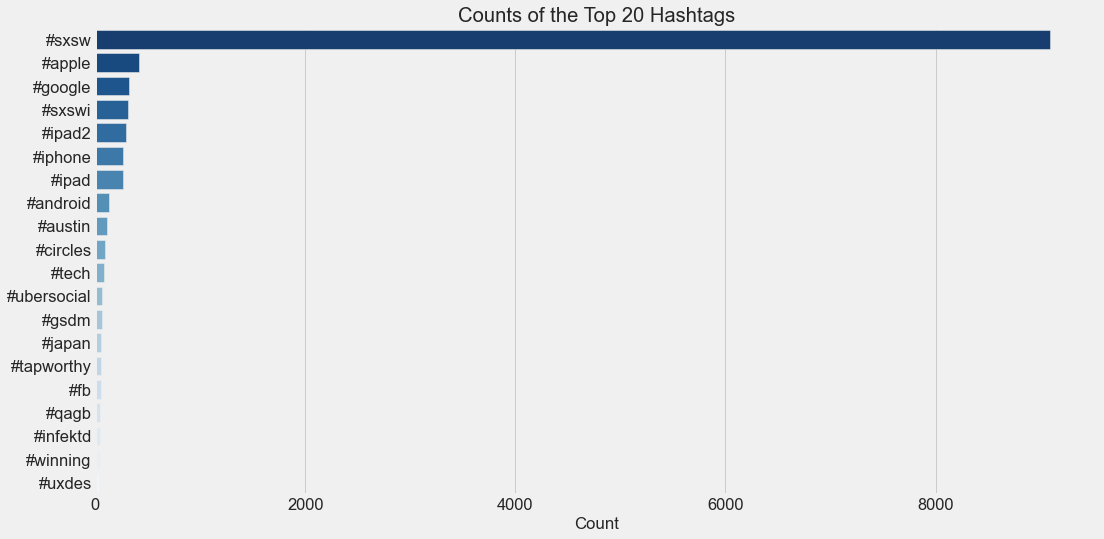

In [34]:
vz.hashtag_c(hts)

In [35]:
hts['hashtags'].value_counts()[:20]

#sxsw          9087
#apple          416
#google         321
#sxswi          316
#ipad2          296
#iphone         265
#ipad           264
#android        131
#austin         112
#circles         98
#tech            87
#ubersocial      68
#gsdm            64
#japan           58
#tapworthy       54
#fb              52
#qagb            50
#infektd         48
#winning         44
#uxdes           40
Name: hashtags, dtype: int64

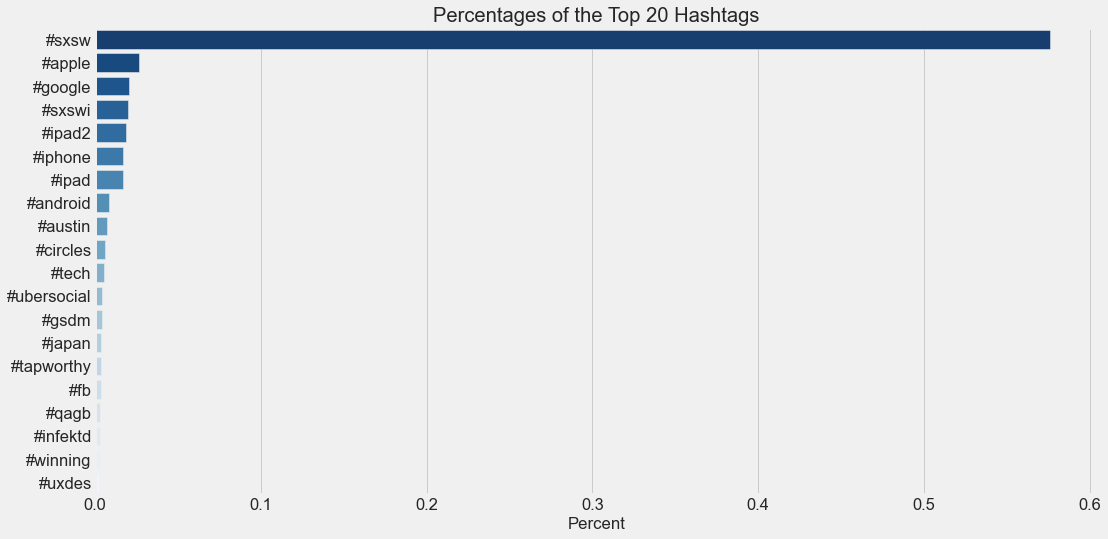

In [36]:
vz.hashtag_p(hts)

In [37]:
hts['hashtags'].value_counts(normalize=True)[:20]

#sxsw          0.575892
#apple         0.026364
#google        0.020343
#sxswi         0.020027
#ipad2         0.018759
#iphone        0.016794
#ipad          0.016731
#android       0.008302
#austin        0.007098
#circles       0.006211
#tech          0.005514
#ubersocial    0.004310
#gsdm          0.004056
#japan         0.003676
#tapworthy     0.003422
#fb            0.003296
#qagb          0.003169
#infektd       0.003042
#winning       0.002789
#uxdes         0.002535
Name: hashtags, dtype: float64

<font size="4">We can see from the graphs above that the vast majority (58%) of the hashtags are `#sxsw`. Every other hashtag is less than 2.7% of the total number of hashtags.</font>

## Checking for RTs
Collecting the retweets checking the count. 

In [38]:
RTs = fn.find_strings(df['tweet'], '(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)')

In [39]:
RTs[:5]

[['RT @madebymany'],
 ['RT @hamsandwich'],
 ['RT @malbonster'],
 ['RT @LaurieShook'],
 ['RT @mention']]

In [40]:
len(RTs)

2551

<font size="4"> There are 2551 retweets. </font>

## Checking for Mentions
Collecting the mentions checking the count

In [41]:
ats = fn.find_strings(df['tweet'], '@[A-Za-z]+[A-Za-z0-9-_]+')
ats[:5]

[['@wesley83'],
 ['@jessedee', '@fludapp'],
 ['@swonderlin'],
 ['@sxsw'],
 ['@sxtxstate']]

In [42]:
len(ats)

4903

<font size="4"> There are 4903 mentions. </font>

## Checking Brand/Product Counts and Frequencies

In [43]:
len(df.brand_product.unique())

10

<font size="4">The are 10 unique values in the `Brand/Product` column including `NaN`.</font>

In [44]:
df.brand_product.isna().sum()/df.shape[0]

0.6381687810259239

<font size="4">63% of the rows have null values in the `Brand/Product` column.</font>

In [45]:
df.brand_product.value_counts().sum()/df.shape[0]

0.3618312189740761

<font size="4">36% of rows have non-null brand data.</font >

In [46]:
df.brand_product.value_counts(normalize=True)

iPad                               0.287500
Apple                              0.200915
iPad or iPhone App                 0.142988
Google                             0.130488
iPhone                             0.090244
Other Google product or service    0.089329
Android App                        0.024390
Android                            0.023476
Other Apple product or service     0.010671
Name: brand_product, dtype: float64

In [47]:
idx = [0, 1, 2, 4, 8]
sum = 0
for i in idx:
    sum += df.brand_product.value_counts(normalize=True)[i]
sum

0.7323170731707316

<font size="4">The Apple brand and Apple products account for 73% of the brand data.</font>

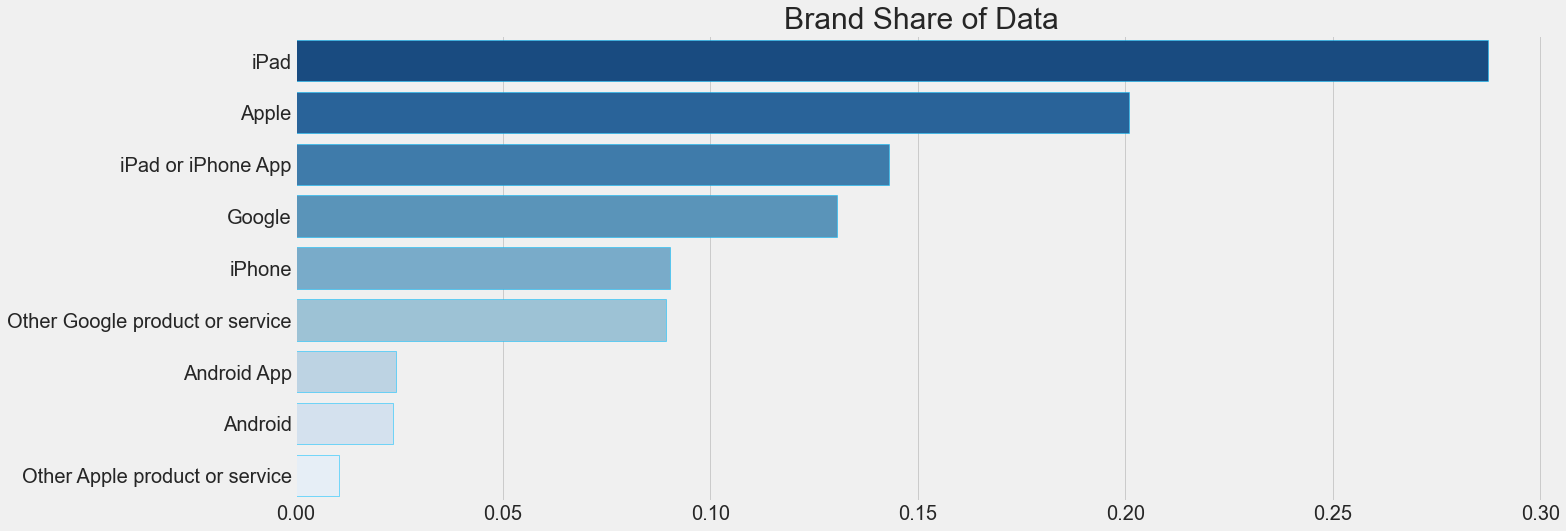

In [48]:
vz.brand_freqs(df)

<font size="4"> The graph above confirm Apple's predominance in the `Brand/Product` column. </font>

## Checking Emotion Unique Values

In [49]:
len(df.emotion.unique())

4

<font size="4">There are 4 unique values in the emotion category.</font>

In [50]:
df.emotion.value_counts()

Neutral         5372
Positive        2968
Negative         569
I can't tell     156
Name: emotion, dtype: int64

In [51]:
df.emotion.value_counts(normalize=True)

Neutral         0.592609
Positive        0.327413
Negative        0.062769
I can't tell    0.017209
Name: emotion, dtype: float64

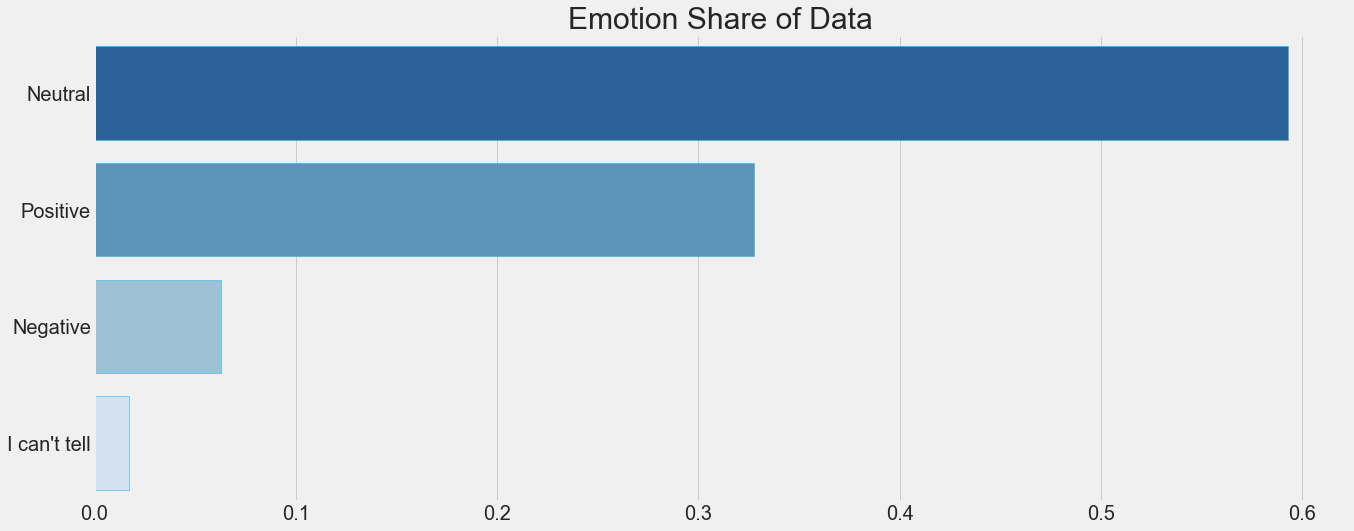

In [52]:
vz.emotion_freqs(df)

<font size="4">`No emotion` accounts for 59% of the data.</font>

<font size="4">`Positive emotion`                   accounts for 33% of the data.</font>

<font size="4">`Negative emotion`                   accounts for 6% of the data.</font>

<font size="4">`I can't tell`                       accounts for 2% of the data.</font>

<font size="4">We want to be able to detect the emotional sentiment of the tweets so we'll drop the `I can't tell` labels.</font>

In [53]:
# getting the original number of rows
before = df.shape[0]

# saving number of 'can't tell' rows
num_cant_tell =df.emotion.value_counts()[3]

# dropping the 'can't tell' rows
df = df[~(df['emotion']=='I can\'t tell')]

# resetting index
df.reset_index(drop=True, inplace=True)

# checking that the number of rows dropped match the number of 'can't tell' rows
before - df.shape[0] == num_cant_tell

True

## Emotions by Brand

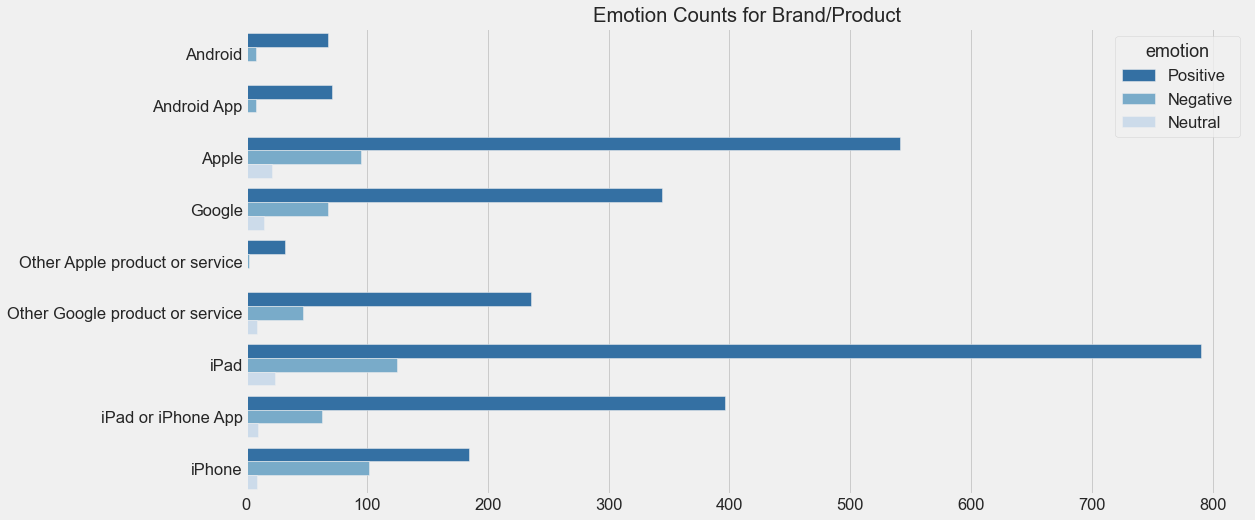

In [54]:
vz.brand_emotions(df)

<font size="4">Apple dominates the tweets with `iPad`, `Apple`, and `iPad or iPhone App` being the subjects of the most tweets.</font>

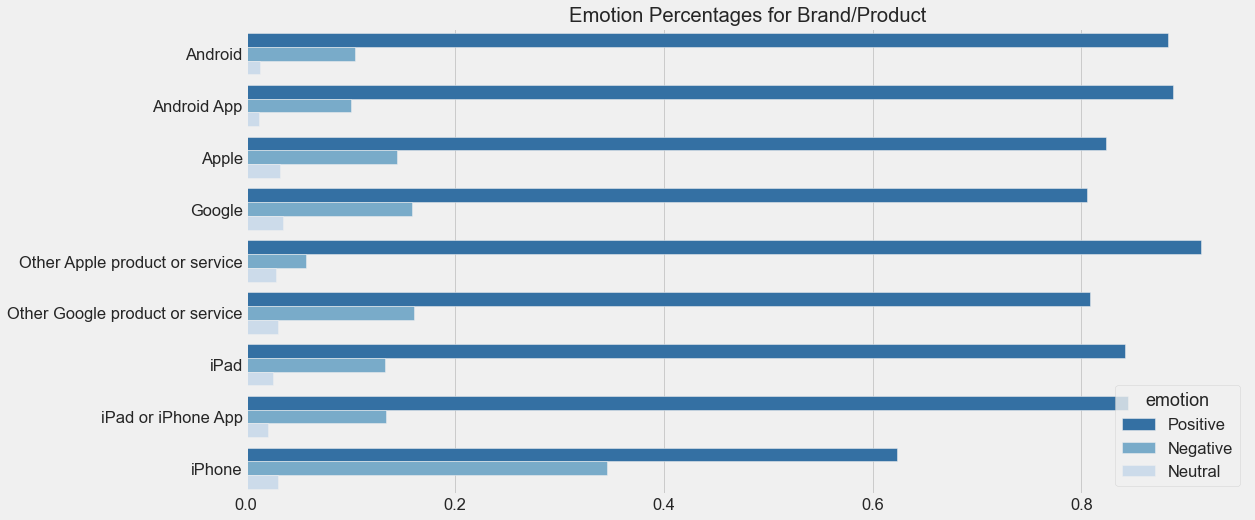

In [55]:
vz.brand_emotion_n(df)

<font size="4">Tweets about product and brands have a strong postive skew, with the only exception being tweets about the iPhone. `iPhone` has a much more mixed ratio of postives and negatives</font>

## Checking Nulls in Product Column

In [56]:
#  filtering down to null porduct data
product_nulls = df[df['brand_product'].isnull()]

In [57]:
# checking first five rows
product_nulls.head()

,tweet,brand_product,emotion,hashtags
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,Neutral,"[#SpeechTherapy, #SXSW, #iear, #edchat, #asd]"
15,Holler Gram for iPad on the iTunes App Store -...,NaN,Neutral,[#sxsw]
31,"Attn: All #SXSW frineds, @mention Register fo...",NaN,Neutral,"[#SXSW, #GDGTLive]"
32,Anyone at #sxsw want to sell their old iPad?,NaN,Neutral,[#sxsw]
33,Anyone at #SXSW who bought the new iPad want ...,NaN,Neutral,[#SXSW]


## Checking The Null Product Data Frame Info

In [58]:
product_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5638 entries, 5 to 8908
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          5638 non-null   object
 1   brand_product  0 non-null      object
 2   emotion        5638 non-null   object
 3   hashtags       5634 non-null   object
dtypes: object(4)
memory usage: 220.2+ KB


## Checking the Null Product Emotion Value Counts & Percentages

In [59]:
product_nulls['emotion'].value_counts()

Neutral     5281
Positive     306
Negative      51
Name: emotion, dtype: int64

In [60]:
product_nulls['emotion'].value_counts(normalize=True)

Neutral     0.936680
Positive    0.054275
Negative    0.009046
Name: emotion, dtype: float64

<font size="4"></font>

<font size="4">Over 90% of tweets with null brand data are  neutral.</font>

## Visualizing Null Brands Emotion Data

In [61]:
null_brand_emotions = df[(df['brand_product'].isna()) &\
                        (df['emotion'] != 'Neutral')]

In [62]:
null_brand_emotions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357 entries, 45 to 8872
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          357 non-null    object
 1   brand_product  0 non-null      object
 2   emotion        357 non-null    object
 3   hashtags       357 non-null    object
dtypes: object(4)
memory usage: 13.9+ KB


## Null Brand Emotion Counts

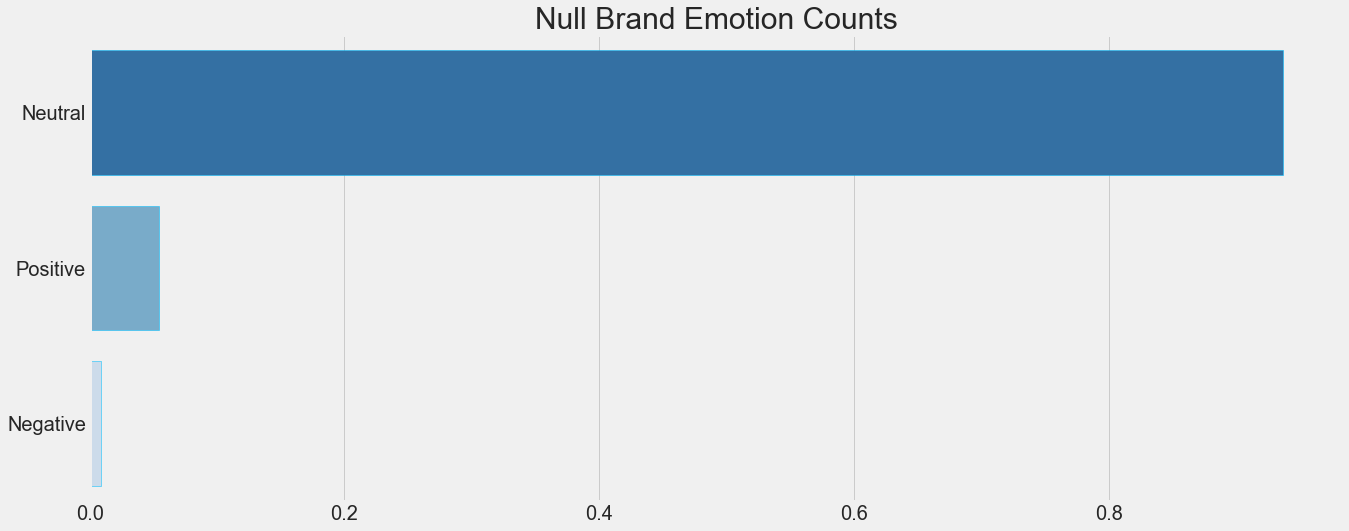

In [63]:
vz.null_brand_emotions(df)

## Examining Some Null Brand Tweets

In [64]:
print(null_brand_emotions.tweet[45])

Hand-Held Û÷HoboÛª: Drafthouse launches Û÷Hobo With a ShotgunÛª iPhone app #SXSW {link}


In [65]:
print(null_brand_emotions.tweet[63])

Again? RT @mention Line at the Apple store is insane.. #sxsw


In [66]:
print(null_brand_emotions.tweet[67])

Boooo! RT @mention Flipboard is developing an iPhone version, not Android, says @mention #sxsw


## Data Preparation II: (Cleaning & Feature Engineering)
The master cleaning functions remove punctuation, urls, retweets, mentions, other unwanted substrings ('{link}', &amp, &quot, &nbsp, &lt, &gt), lower case all letters, and return a list of clean and regularized (lemmas and stems) tweets.

In [67]:
fn.clean_tweet_lem(df.tweet[0])

['3g',
 'iphone',
 'hr',
 'tweeting',
 'rise',
 'austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'station']

In [68]:
data_clean_lemmas = fn.clean_corpus_lem(df.tweet)

data_clean_stems = fn.clean_corpus_stem(df.tweet)

## Comparing Raw Tweets to the Cleaned & Regularized Tweets

In [69]:
for i in range(100):
    print(f'original: {df.tweet[i]}\n')
    print(f'lemms: {data_clean_lemmas[i]}')
    print(f'stems: {data_clean_stems[i]}\n')

original: .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.

lemms: 3g iphone hr tweeting rise austin dead need upgrade plugin station
stems: 3g iphon 3 hr tweet rise austin dead need upgrad plugin station

original: @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW

lemms: know awesome ipad iphone app likely appreciate design also giving free t
stems: know awesom ipad iphon app like appreci design also give free ts

original: @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.

lemms: wait ipad also sale
stems: wait ipad also sale

original: @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw

lemms: hope year festival crashy year iphone app
stems: hope year festiv crashi year iphon app

original: @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim 

<font size="4">Looks good, so we''ll add the lemmatized and stemmed tweets  to the data frame as columns.</font>

## Adding Cleaned Data to DF

In [70]:
df['lemmas'] = data_clean_lemmas

In [71]:
df['stems'] = data_clean_stems

In [72]:
df.head()

,tweet,brand_product,emotion,hashtags,lemmas,stems
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,"[#RISE_Austin, #SXSW]",3g iphone hr tweeting rise austin dead need up...,3g iphon 3 hr tweet rise austin dead need upgr...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,[#SXSW],know awesome ipad iphone app likely appreciate...,know awesom ipad iphon app like appreci design...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,"[#iPad, #SXSW]",wait ipad also sale,wait ipad also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,[#sxsw],hope year festival crashy year iphone app,hope year festiv crashi year iphon app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,[#SXSW],great stuff fri marissa mayer google tim reill...,great stuff fri marissa mayer googl tim reilli...


In [73]:
df.lemmas[0]

'3g iphone hr tweeting rise austin dead need upgrade plugin station'

## Checking for Nulls & Empty Cells

In [74]:
# checking for nulls
df.isnull().sum()

tweet               0
brand_product    5638
emotion             0
hashtags           10
lemmas              0
stems               0
dtype: int64

In [75]:
# checking for blank cells
np.where(df.applymap(lambda x: x == ''))

(array([4925, 4925]), array([4, 5]))

## Dropping Row With Empty Cells

In [76]:
df.drop(4925, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

## Making the `emotion` Target Numeric

In [77]:
# checking counts
df.emotion.value_counts()

Neutral     5371
Positive    2968
Negative     569
Name: emotion, dtype: int64

In [78]:
# changing to ints
df['emotion'] = df['emotion'].replace(['Negative',
                                       'Positive',
                                       'Neutral'],
                                       [1, 0, 2])

In [79]:
# re-checking counts
df['emotion'].value_counts()

2    5371
0    2968
1     569
Name: emotion, dtype: int64

## Moving the Target and Regularized Columns to the Front of the Data Frame

In [80]:
cols = ['lemmas', 'stems', 'emotion']

for col in cols:
    c = df.pop(col)
    df.insert(0, col, c)
    
# checking work
df.head()

,emotion,stems,lemmas,tweet,brand_product,hashtags
0,1,3g iphon 3 hr tweet rise austin dead need upgr...,3g iphone hr tweeting rise austin dead need up...,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,"[#RISE_Austin, #SXSW]"
1,0,know awesom ipad iphon app like appreci design...,know awesome ipad iphone app likely appreciate...,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,[#SXSW]
2,0,wait ipad also sale,wait ipad also sale,@swonderlin Can not wait for #iPad 2 also. The...,iPad,"[#iPad, #SXSW]"
3,1,hope year festiv crashi year iphon app,hope year festival crashy year iphone app,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,[#sxsw]
4,0,great stuff fri marissa mayer googl tim reilli...,great stuff fri marissa mayer google tim reill...,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,[#SXSW]


## Exporting Data for Modeling

In [81]:
# path = os.path.join(gparent, 'data/processed', 'baseline_data.csv')
# df.to_csv(path, index=False)

## Exporting Data for Visualizations

In [82]:
# # converting the target integers to strings for the visualiztions
# df['emotion'] = df['emotion'].replace([1, 0, 2],
#                                       ['Negative',
#                                        'Positive',
#                                        'Neutral']
#                                       )

# path = os.path.join(gparent, 'data/processed', 'report_baseline_viz.csv')
# df.to_csv(path, index=False)

## EDA on Clean, Regularized Data

## Word Frequency Distributions of Raw vs Cleaned Data

#### Raw Data

In [83]:
fn.word_frequencies(df.tweet, 30)

Word 			Frequency

mention   		0.0685    
link      		0.0415    
rt        		0.0285    
google    		0.0254    
ipad      		0.0242    
apple     		0.0225    
quot      		0.0162    
iphone    		0.0152    
store     		0.0143    
2         		0.0115    
new       		0.0105    
austin    		0.0093    
amp       		0.0081    
app       		0.008     
social    		0.0064    
circles   		0.0064    
launch    		0.0062    
android   		0.0058    
pop       		0.0057    
today     		0.0056    
ipad2     		0.0045    
network   		0.0044    
via       		0.0042    
line      		0.0039    
get       		0.0038    
free      		0.0038    
party     		0.0034    
called    		0.0034    
mobile    		0.0034    
one       		0.003     


## Visualizing the Top 25 Words in the Raw Data

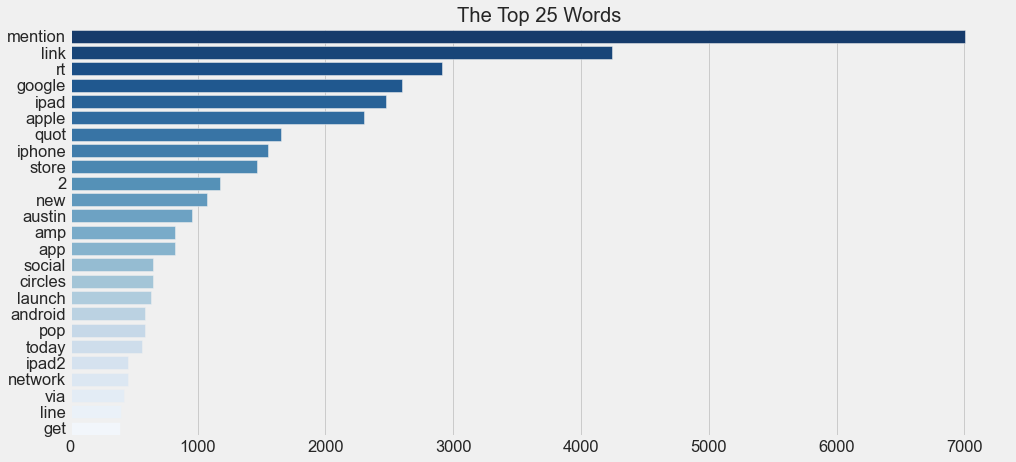

In [84]:
raw_words = fn.words(df.tweet)
vz.top_word_list(raw_words, 25)

<font size="4"> We can see the 3 out of the top 5 words in the raw data are unrelated to the relevant brands.</font>

#### Lemmatized Data

In [85]:
fn.word_frequencies(df.lemmas, 25)

Word 			Frequency

ipad      		0.0358    
google    		0.0317    
apple     		0.0281    
iphone    		0.019     
store     		0.0183    
new       		0.0131    
austin    		0.0117    
app       		0.01      
launch    		0.0082    
circle    		0.0081    
social    		0.0079    
android   		0.0072    
pop       		0.0072    
today     		0.0069    
network   		0.0056    
get       		0.0055    
line      		0.0054    
via       		0.0052    
party     		0.0048    
free      		0.0047    
mobile    		0.0043    
called    		0.0042    
one       		0.0038    
time      		0.0037    
like      		0.0036    


## Visualizing the Top 25 Words in the Lemmatized Data

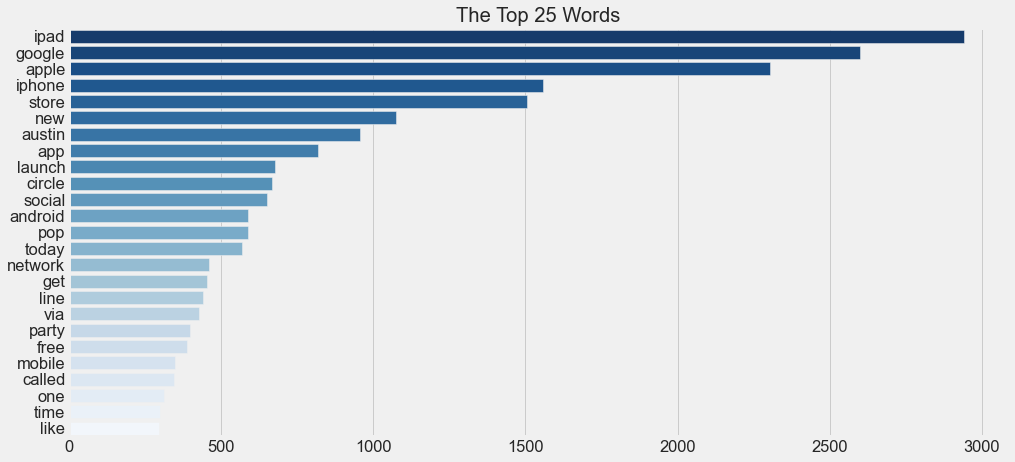

In [86]:
lemm_words = fn.words(df.lemmas)
vz.top_word_list(lemm_words, 25)

<font size="4"> 4 out of the top 5 words in the lemmatized data are related to the relevant brands.</font>

#### Stemmed Data

In [87]:
fn.word_frequencies(df.stems, 25)

Word 			Frequency

googl     		0.031     
ipad      		0.0305    
appl      		0.0274    
iphon     		0.0186    
store     		0.0179    
new       		0.0128    
app       		0.0124    
austin    		0.0114    
launch    		0.0098    
circl     		0.0079    
social    		0.0078    
pop       		0.0072    
android   		0.007     
today     		0.0068    
get       		0.0063    
open      		0.0063    
network   		0.0056    
ipad2     		0.0056    
line      		0.0054    
via       		0.0051    
go        		0.005     
parti     		0.0048    
call      		0.0046    
free      		0.0046    
mobil     		0.0042    


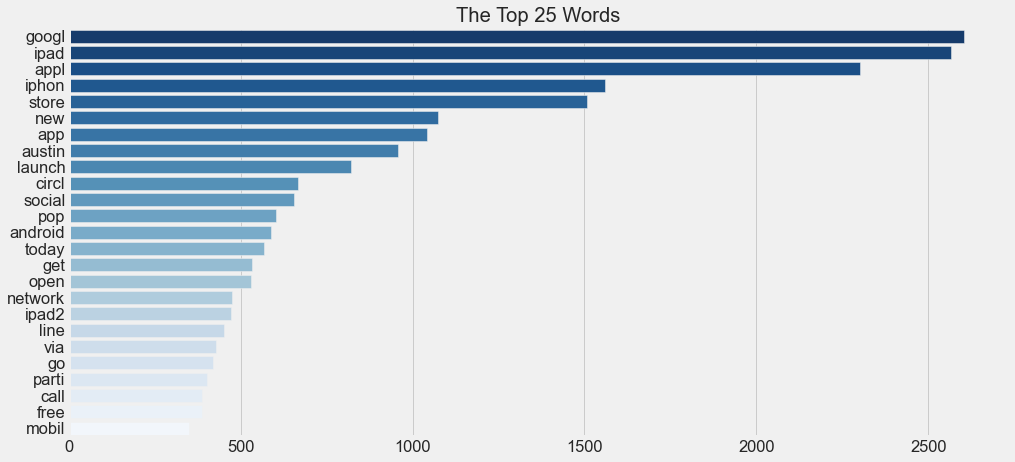

In [88]:
stem_words = fn.words(df.stems)
vz.top_word_list(stem_words, 25)

<font size="4">Again,  4 out of the top 5 words in the stemmed data are related to the relevant brands.</font>

## Vocabularies
Checking the size of the vocabularies and looking at a sample of the tokens.

#### Lemmas Vocabulary

In [89]:
lemma_vocab = fn.vocabulary(data_clean_lemmas)

In [90]:
# checking number of words
len(lemma_vocab)

8351

<font size="4">There are 8,351 tokens in the lemmatized data.</font>

## A sampling of the Lemmas

In [91]:
# first 100 words
for i, val in enumerate(itertools.islice(lemma_vocab, 100)):
    print(val)

tshirts
miracle
deficit
nab
navigate
quotables
lawn
cleared
name
written
incubator
guykawasaki
niceness
nearby
regard
glowing
optimum
snakeheead
hacker
tricket
barcode
archive
analytics
crowdsource
palsy
table
standing
hometown
cloudsight
thereby
twittering
socnet
frabjous
pdparticle
sketchy
african
hhaha
staircase
worship
bigdplace
terror
stretching
1am
christian
typo
androidhig
nexus
ridicule
divorce
set
consideration
primero
popoup
absolutley
north
smileyparty
dock
mindtouch
savvy
provider
shortcut
shoulda
lord
cry
ht
advance
merchant
supply
feeling
replaced
agenda
blow
donating
androidcrunch
denotes
mm
portfolio
indexed
dugan
w0t
entered
bill
elevator
rough
drooling
pdx
never
reconsidering
worst
prove
pagerduty
sleep
rite
knockout
linking
iphonedev
latam
brush
lunatik
tip


In [92]:
# random 100 words
for i, val in enumerate(random.sample(lemma_vocab, 100)):
    print(val)

org
grouped
lifelinetotheworld
mp
dispenses
wt
promoting
lugging
enuf
xwave
local
keeping
outsold
punctuate
caring
niche
8pm
crappy
skull
entire
per
restroomi
connect
alert
mophie
front
rollout
ohio
intelligence
autocorrects
connecting
pcmag
rediculous
gtd
networkcircles
ctia
game
horizon
cure
recollection
exposing
amer
wake
newsweek
curated
gamesalad
fsw
jenny
thewildernessdowntown
irrelevant
hit
2gb
pdf
meyers
concept
techenvy
3x
notwinning
bomb
jut
cnngrill
nc
purchaser
handset
sxswsex
futuremf
googleblog
simultaneously
perimeter
taste
pushed
willpower
desmiente
techsmith
banana
stone
amazing
hookup
screenfuture
giveaway
fr
release
spoken
mostly
staying
tournament
frid
easeljs
heating
ifrom
cart
videogame
expecting
handled
en6p2e
presenter
priest
debut
nutter
pandora


#### Stems Vocabulary

In [93]:
stemma_vocab = fn.vocabulary(data_clean_stems)

In [94]:
# number of words
len(stemma_vocab)

7379

<font size="4">There are 7,379 tokens in the stemmed data.</font>

## A sampling of the stems.

In [95]:
# random 100 words
for i, val in enumerate(random.sample(stemma_vocab, 100)):
    print(val)

juwan
kia
bit
verg
incred
boston
traffic
happen
parent
plu
stinkin
xcitng
also
cera
okay
gawk
globalmoxi
shatter
z8
crew
reset
soundtrax
brazo
605
fabul
independ
gowalla
hollrback
z43
tuesday
memolan
corrupt
optimum
superhappydevhous
ass
irelay
cach
sxswtoolkit
gmap
zap
theindustryparti
mahalo
qualifi
baracad
conflagr
att
shrink
obama
keep
011
east
shipment
receiv
wt
ooooo
behind
enhanc
rana
stevemartocci
bo
pair
yyz
andi
guess
ground
mkt
strike
rare
match
coolaid
weasel
rise
btw
buddi
amount
c10
fenc
ht
muffin
handsom
recip
china
128
layar
marisa
panic
accelerat
doofus
guguchu
facial
maximum
technologist
browser
scope
imthatgood
ipaddesignheadach
imaconf
illustr
sixth
z1


In [96]:
# first 100 words
for i, val in enumerate(itertools.islice(stemma_vocab, 100)):
    print(val)

deficit
pushsnowboard
nab
lawn
name
written
guykawasaki
somebodi
of011
regard
c9
moder
peac
optimum
spasmat
snakeheead
parcelgeni
yeasay
hacker
tricket
thinmint
hipstamat
besid
hometown
googledoodl
artifici
adventur
cloudsight
texas011
socnet
what
ubergeniu
wannab
african
18
hhaha
frankeninterfac
worship
terror
stall
observ
christian
typo
carri
androidhig
tremend
800
set
primero
melodi
popoup
absolutley
north
dock
mindtouch
shortcut
shoulda
lord
confin
ht
merchant
radiu
blow
agenda
androidcrunch
mm
portfolio
dugan
bill
miin
rough
pdx
never
ts
expens
worst
prove
servic
unconfirm
sleep
rite
knockout
iphonedev
latam
brush
lunatik
tip
trajan
h4cker
lone
alguien
smack
toooo
shareabl
profession
purchas
iwantacameraonmyipad
sure
test
plze


In [97]:
fn.string_checker(stemma_vocab, 'https')
fn.string_checker(stemma_vocab, 'madebymany')

string is not in data
string is not in data


## Augmenting the data
Poor performance of the baseline model was largely due the the extreme class imbalance of the original data, so minority class oversampling and SMOTE methods were implemented. These strategies provided improved performance in the baseline model, but the results were still unsatisfactory.  Various other model types were tested with the oversampled data, but the performance of these alternative models was also poor.

In the end, additional negative sentiment data obtained from [Kaggle](https://www.kaggle.com/shashank1558/preprocessed-twitter-tweets) and [data.world](https://data.world/crowdflower/apple-twitter-sentiment) were used to augment the baseline data. This new data greatly imroved the performance of all the models and the final results are detailed below.

#### General Negative Tweets
Data downloaded from: [Kaggle](https://www.kaggle.com/shashank1558/preprocessed-twitter-tweets)

The data was one of a set of three (negative, neutral, positve) csv files.

In [98]:
# setting the path
path = os.path.join(gparent, 'data/raw', 'processedNegative.csv')

# loading the data
load_df = pd.read_csv(path, encoding='unicode_escape')

In [99]:
# checking the head of the df
load_df.head()

,How unhappy some dogs like it though,talking to my over driver about where I'm goinghe said he'd love to go to New York too but since Trump it's probably not,Does anybody know if the Rand's likely to fall against the dollar? I got some money I need to change into R but it keeps getting stronger unhappy,I miss going to gigs in Liverpool unhappy,There isnt a new Riverdale tonight ? unhappy,it's that A*dy guy from pop Asia and then the translator so they'll probs go with them around Aus unhappy,Who's that chair you're sitting in? Is this how I find out. Everyone knows now. You've shamed me in pu,don't like how jittery caffeine makes me sad,My area's not on the list unhappy think I'll go LibDems anyway,I want fun plans this weekend unhappy,...,and yet if parents invest in child's emotional education by taking child out of school on holiday early that's un,YG should have sent them to MCD. I want to see them holding the trophy unhappy anyways .9,i want more orientation unhappy,unhappy they not,YG should have sent them to MCD. I want to see them holding the trophy unhappy anyways .10,wish knock out lang talaga for the new school year are good and cooperative groupmates please unhappy,i miss so much unhappy,Same unhappy .1,Hi instant message your friend friend lang,hindi close friend? unhappy


<font size="4">The data is arranged as column names and needs to be re-formatted.</font>

## Getting the Data into a Usable Format
Creating a data frame, adding `tweet` and `emotion` columns, and setting the `emotion` values to 1.

In [100]:
#  making a list of tweets
tweets = [col for col in load_df.columns]

In [101]:
# creating a data frame
neg_df = pd.DataFrame(tweets, columns=['tweet'])

In [102]:
# creating an emotion col and setting its values to 1
neg_df['emotion'] = 1

In [103]:
# checking work
print(neg_df.info())
neg_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117 entries, 0 to 1116
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    1117 non-null   object
 1   emotion  1117 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 17.6+ KB
None


,tweet,emotion
0,How unhappy some dogs like it though,1
1,talking to my over driver about where I'm goin...,1
2,Does anybody know if the Rand's likely to fall...,1
3,I miss going to gigs in Liverpool unhappy,1
4,There isnt a new Riverdale tonight ? unhappy,1


## Negative Apple Tweets
Data obtained from: [data.world](https://data.world/crowdflower/apple-twitter-sentiment)

The data labels were numeric and a key was not provided, so we will have to examine to tweets and deduce which label corresponds to negative.

## Loading the Data and Creating a DF

In [104]:
# setting the path
path = os.path.join(gparent, 'data/raw', 'Apple-Twitter-Sentiment-DFE.csv')

# loading the data
apple_df = pd.read_csv(path, encoding='unicode_escape')

In [105]:
# checking the first five rows
apple_df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL


## Checking the Info & Sentiment Value Counts

In [106]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _unit_id              3886 non-null   int64  
 1   _golden               3886 non-null   bool   
 2   _unit_state           3886 non-null   object 
 3   _trusted_judgments    3886 non-null   int64  
 4   _last_judgment_at     3783 non-null   object 
 5   sentiment             3886 non-null   object 
 6   sentiment:confidence  3886 non-null   float64
 7   date                  3886 non-null   object 
 8   id                    3886 non-null   float64
 9   query                 3886 non-null   object 
 10  sentiment_gold        103 non-null    object 
 11  text                  3886 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 337.9+ KB


In [107]:
apple_df.sentiment.value_counts()

3               2162
1               1219
5                423
not_relevant      82
Name: sentiment, dtype: int64

<font size="4">The sentiment values are actually strings and will have to be converted to numeric.</font>

## Checking the Sentiment of Label 1.

In [108]:
# filtering and. checking the first five rows
apple_df[apple_df.sentiment=='1'].head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
10,623495523,True,golden,12,NaN,1,1.0000,Mon Dec 01 20:46:01 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...
14,623495527,True,golden,17,NaN,1,1.0000,Mon Dec 01 21:09:50 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,@apple Contact sync between Yosemite and iOS8 ...
16,623495529,True,golden,16,NaN,1,0.9399,Mon Dec 01 21:35:14 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,WARNING IF YOU BUY AN IPHONE 5S UNLOCKED FROM ...
23,623495536,True,golden,13,NaN,1,1.0000,Mon Dec 01 23:55:55 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,"@Apple, For the love of GAWD, CENTER the '1'on..."
24,623495537,True,golden,9,NaN,1,0.8928,Tue Dec 02 00:06:05 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,i get the storage almost full notification lit...


In [109]:
apple_df[apple_df.sentiment=='1'].text[10]

'WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW IS 29% WTF IS THIS @apple'

<font size="4">These tweets look pretty negative, so it seems like we found the label we need.</font>

## Creating a DF of the Negative Tweets

In [110]:
# filtering down to the negatives
appl_neg = apple_df[apple_df.sentiment=='1']

# making a df of just the text and sentiment columns
a_neg = appl_neg[['text', 'sentiment']].copy()

# converting sentiment values to numeric
a_neg['sentiment'] = a_neg['sentiment'].apply(pd.to_numeric)

# renaming the columns
a_neg.rename(columns={'sentiment': 'emotion', 'text': 'tweet'}, inplace=True)

# reseting the index
a_neg.reset_index(drop=True, inplace=True)

## Checking Work

In [111]:
print(a_neg.info())
a_neg.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1219 entries, 0 to 1218
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    1219 non-null   object
 1   emotion  1219 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 19.2+ KB
None


,tweet,emotion
0,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...,1
1,@apple Contact sync between Yosemite and iOS8 ...,1
2,WARNING IF YOU BUY AN IPHONE 5S UNLOCKED FROM ...,1
3,"@Apple, For the love of GAWD, CENTER the '1'on...",1
4,i get the storage almost full notification lit...,1


## Joining The Data Frames & Checking Info

In [112]:
neg_aug = pd.concat([a_neg, neg_df], axis=0, ignore_index=True)

In [113]:
neg_aug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2336 entries, 0 to 2335
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    2336 non-null   object
 1   emotion  2336 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 36.6+ KB


## Getting the New DF in a Format Compatible with the Original DF

## Setting the Hashtag Columns

In [114]:
# copying hashtags to a new column and setting any empty lists to NaNs
neg_aug['hashtags'] = neg_aug['tweet'].apply(lambda x: 
                                   re.findall(r'\B#\w*[a-zA-Z]+\w*', x))
neg_aug['hashtags'] = neg_aug['hashtags'].apply(lambda x: np.nan if len(x) == 0 else x)

In [115]:
neg_aug.head()

,tweet,emotion,hashtags
0,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...,1,NaN
1,@apple Contact sync between Yosemite and iOS8 ...,1,"[#icloud, #isync]"
2,WARNING IF YOU BUY AN IPHONE 5S UNLOCKED FROM ...,1,NaN
3,"@Apple, For the love of GAWD, CENTER the '1'on...",1,NaN
4,i get the storage almost full notification lit...,1,NaN


## Cleaning and Regularizing the Tweets

In [116]:
data_clean_lemmas = fn.clean_corpus_lem(neg_aug.tweet)
data_clean_stems = fn.clean_corpus_stem(neg_aug.tweet)

## Adding the `lemmas` & `stems` Columns

In [117]:
neg_aug['lemmas'] = data_clean_lemmas
neg_aug['stems'] = data_clean_stems

## Adding the `brand_product` column

In [118]:
neg_aug['brand_product'] = np.nan

## Checking Work

In [119]:
neg_aug.head()

,tweet,emotion,hashtags,lemmas,stems,brand_product
0,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...,1,NaN,wtf battery one second ago wtf,wtf batteri 31 one second ago is9 wtf,NaN
1,@apple Contact sync between Yosemite and iOS8 ...,1,"[#icloud, #isync]",contact sync yosemite io seriously screwed use...,contact sync yosemit ios8 serious screw use mu...,NaN
2,WARNING IF YOU BUY AN IPHONE 5S UNLOCKED FROM ...,1,NaN,warning buy iphone 5 unlocked iphone cannot us...,warn buy iphon 5s unlock iphon cannot use veri...,NaN
3,"@Apple, For the love of GAWD, CENTER the '1'on...",1,NaN,love gawd center damn calendar app fixed back ...,love gawd center 1 damn calendar app fix back ...,NaN
4,i get the storage almost full notification lit...,1,NaN,get storage almost full notification literally...,get storag almost full notif liter everi 5 min...,NaN


## Word Frequencies of the New Data
The new data contains profanity so some tokens will altered before they are displayed.

In [120]:
clean = fn.cloud_cleaner_lem(neg_aug.lemmas)

In [121]:
fn.word_frequencies(clean, 25)

Word 			Frequency

unhappy   		0.05      
apple     		0.0113    
iphone    		0.0092    
need      		0.0091    
phone     		0.0087    
one       		0.0086    
aapl      		0.0084    
get       		0.0077    
f0ck      		0.0071    
battery   		0.0068    
want      		0.0068    
like      		0.0064    
computer  		0.0061    
u         		0.0061    
make      		0.006     
sh1t      		0.0056    
please    		0.0053    
people    		0.0051    
sad       		0.0049    
future    		0.0048    
studio    		0.0047    
ft        		0.0047    
fix       		0.0046    
outlet    		0.0046    
miss      		0.0045    


Unhappy has the greatest frequency at 5%, and is about five times more common than the next most common word.

## Joining the Old and New DFs & Checking the Class Balance

In [122]:
# joining dfs
augmented = pd.concat([df, neg_aug], axis=0, ignore_index=True)

# checking class balance
augmented.emotion.value_counts(normalize=True)

2    0.477677
0    0.263963
1    0.258360
Name: emotion, dtype: float64

<font size="4">The class balance is looking much more resonable now.</font>

In [123]:
augmented.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11244 entries, 0 to 11243
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion        11244 non-null  int64 
 1   stems          11244 non-null  object
 2   lemmas         11244 non-null  object
 3   tweet          11244 non-null  object
 4   brand_product  3271 non-null   object
 5   hashtags       9236 non-null   object
dtypes: int64(1), object(5)
memory usage: 527.2+ KB


## Cleaning up Blank Tweets

In [123]:
# checking for blank cells
np.where(augmented.applymap(lambda x: x == ''))

(array([10699, 10699, 11048, 11048]), array([1, 2, 1, 2]))

In [124]:
augmented.drop([10699, 11048], axis=0, inplace=True)
augmented.reset_index(drop=True, inplace=True)

## Exporting Augmented Data for Modeling

In [125]:
# path = os.path.join(gparent, 'data/processed', 'augmented_data.csv')
# augmented.to_csv(path, index=False)

## Exporting Augmented Data for Visualizations

In [126]:
# # converting the target integers to strings for the visualiztions
# augmented['emotion'] = augmented['emotion'].replace([1, 0, 2],
#                                       ['Negative',
#                                        'Positive',
#                                        'Neutral']
#                                       )

# path = os.path.join(gparent, 'data/processed', 'report_aug_viz.csv')
# # augmented.to_csv(path, index=False)